# Clean!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from behavelet import wavelet_transform
from sklearn.decomposition import PCA 

# K-MEAN
from sklearn.cluster import KMeans
# GMM clustering
from sklearn import mixture
#correlation
import seaborn as sns

C:\Users\Haha\anaconda3\lib\site-packages\behavelet\morlet.py:26: UserWarning: CuPy was not found, so GPU functionality is unavailable. See https://github.com/cupy/cupy#installation for installation instructions
  warnings.warn('CuPy was not found, so GPU functionality is unavailable. '


# Loading the behavioural/neural data

In [2]:
beh_data_dir = "data/COBAR_behaviour_incl_manual.pkl"
beh_df = pd.read_pickle(beh_data_dir)


In [3]:
neural_data_dir = beh_data_dir = "data/COBAR_neural.pkl"
neural_df = pd.read_pickle(neural_data_dir)


## Part 2: Data pre-processing

### 1. ΔF/F

In [4]:
#Δ𝐹/𝐹 = (F − Fb)/𝐹b , where Fb is the baseline fluorescence.
# return baselined neural data
def neural_dF_F(data):
    rlt_Df_f=data.copy()
    nb_neurons = np.size(data,1)
    
    for j in np.arange(nb_neurons-1): 
        baseline = data['neuron_' + str(j)].rolling(window=3).mean()
        rlt_Df_f['neuron_' + str(j)] = (data['neuron_' + str(j)]-abs(baseline.min()))/abs(baseline.min())
    return rlt_Df_f

### 2. Noise reduction

In [5]:
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

#filter angles in beh data
fs=100.0
order=2
cutoff=20
filtered_beh_df = beh_df.copy(deep=True)
angl=beh_df.filter(regex="angle")
filtered_angl = butter_lowpass_filter(angl, cutoff, fs, order)
filtered_beh_df.iloc[:,2:44]=filtered_angl
#filter neurons reading in neural data
filtered_neural_df = neural_df.copy(deep=True) #necessary to deep copy dataaframe
fs=16.0
order=2
cutoff=2.5
neurons=neural_df.filter(regex="neuron")
filtered_neurons = butter_lowpass_filter(neurons, cutoff, fs, order)
filtered_neural_df.iloc[:,1:124]=filtered_neurons

filtered_neural_df = neural_dF_F(filtered_neural_df)

# Investigate clustering of neurons' activity: find neurons that correlate with each other

This section aims at finding neurons that activate at similar times. This is done by doing a Principal Component Analysis (PCA) followed by clastering. The clastering is then evaluated using inter-neuron correlation.

## PCA 

In [33]:
# Functions required for PCA 

# normalise the data
def normalise(data):
    Feature_scaler = sklearn.preprocessing.StandardScaler().fit(data)
    return sklearn.preprocessing.scale(data)

# apply PCA:  
# input samples: neurons
# input features: time samples
def PCA_temporal(data_norm, plot=False):

    pca = PCA(n_components=5)
    data_new = pca.fit_transform(data_norm.T)
    print(pca.explained_variance_ratio_)
    
    if plot:
        #plot loadings
        loadings = pd.DataFrame(pca.components_[0:2].T, columns=['PC1', 'PC2'])
        plt.plot(loadings['PC1'], label = 'PC1')
        plt.plot(loadings['PC2'], label = 'PC2')
        plt.title('PCA loadings')
        plt.xlabel('feature')
        plt.ylabel('PCA weight')
        plt.legend()
        plt.show()
        
        #scatter plot of first two components
        plt.scatter(data_new[:,0], data_new[:,1], alpha = 0.5) 
        plt.title('First two PCs')
        plt.xlabel('PC 1,   variance={:.2f}'.format(pca.explained_variance_ratio_[0]))
        plt.ylabel('PC 2,   variance={:.2f}'.format(pca.explained_variance_ratio_[1]))
        plt.show()
    return data_new

[0.27332419 0.26424122 0.06765547 0.03619374 0.0326937 ]


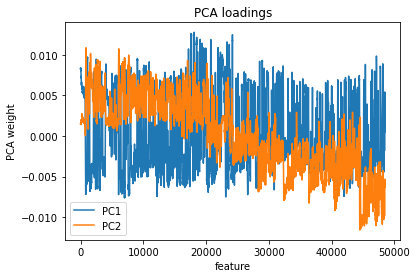

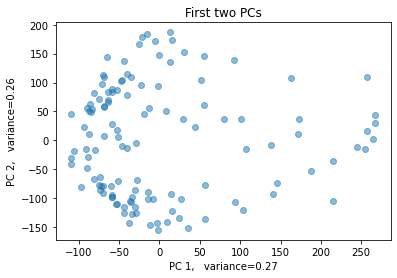

In [34]:
# all neurons are used as data
X = filtered_neural_df.filter(regex="neuron")
X_norm = normalise(X)
X_new = PCA_temporal(X_norm, plot=True)

## clustering
After the dimension reduction done with the PCA, the neurons can be clastered. These clusters represent neurons that have similar signals.

In [35]:
# cluster data using kmeans
# returns the classes and class names
def kmeans_cluster(data, nb_clusters, plot=False):
    
    #fit kmeans
    kmeans = KMeans(n_clusters=nb_clusters, init='random', n_init=1, verbose=0)
    kmeans.fit(data)
    labels = kmeans.labels_
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of KMEANS clusters
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('KMEANS clustering')
        plt.legend(class_names)
        plt.show()
    
    return labels, class_names

# cluster data using GMM
# returns the classes and class names
def GMM_cluster(data, nb_components, plot=False):
    
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=nb_components, covariance_type='full').fit(data)
    
    labels = gmm.predict(data)
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of GMM clusters
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('GMM clustering')
        plt.legend(class_names)
        plt.show()
        
    return labels, class_names

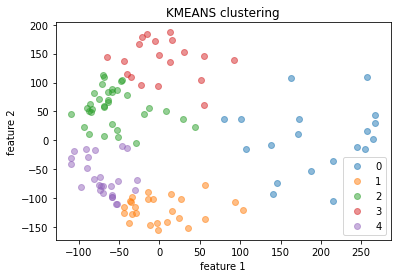

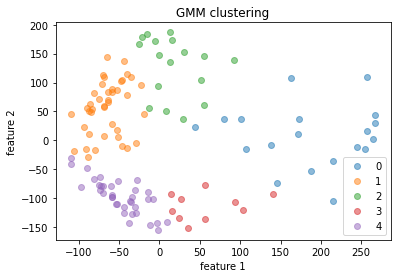

In [38]:
kmeans_labels1, kmeans_names1 = kmeans_cluster(X1_new, nb_clusters=5, plot=True)
GMM_labels1, GMM_names1 = GMM_cluster(X1_new, nb_components=5, plot=True)

## Correlation
To evaluate the similarity between the signals of neurons from the same cluster, we can find their correlation coefficients.

In [49]:
# plot correlation coefficient of given data
def plot_correlation_coeff(data, title):
    #Set up the matplotlib figure
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10))

    #Compute the correlation matrix
    correlation = data

    corr = correlation.corr()

    #Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    #Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_xlabel('neuron id')
    ax.set_ylabel('neuron id')
    ax.title.set_text(title)

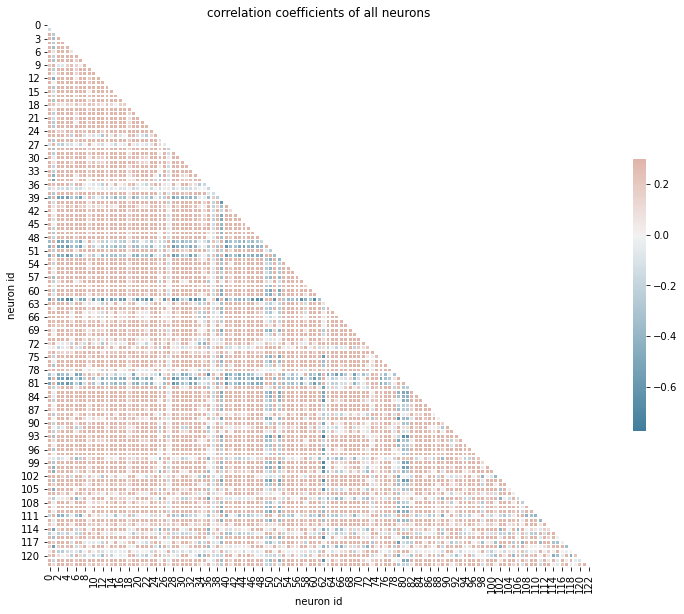

In [51]:
# correlation coefficient of all the neurons
plot_correlation_coeff(pd.DataFrame(data=X1_norm), title='correlation coefficients of all neurons')

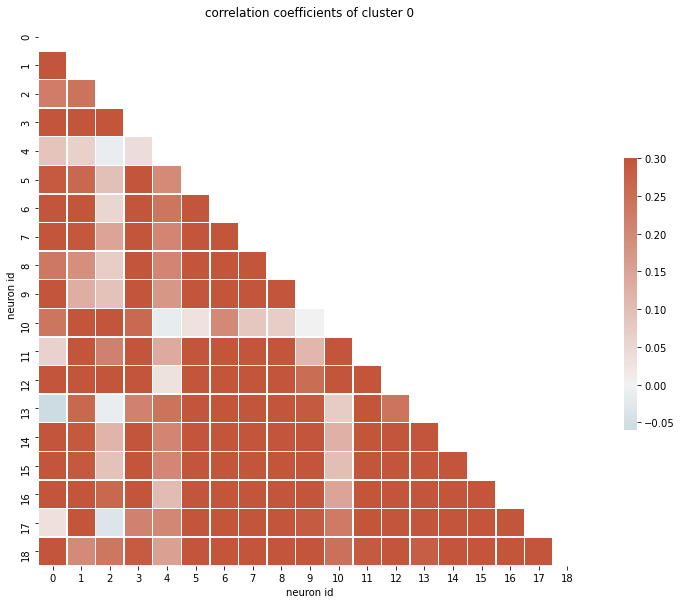

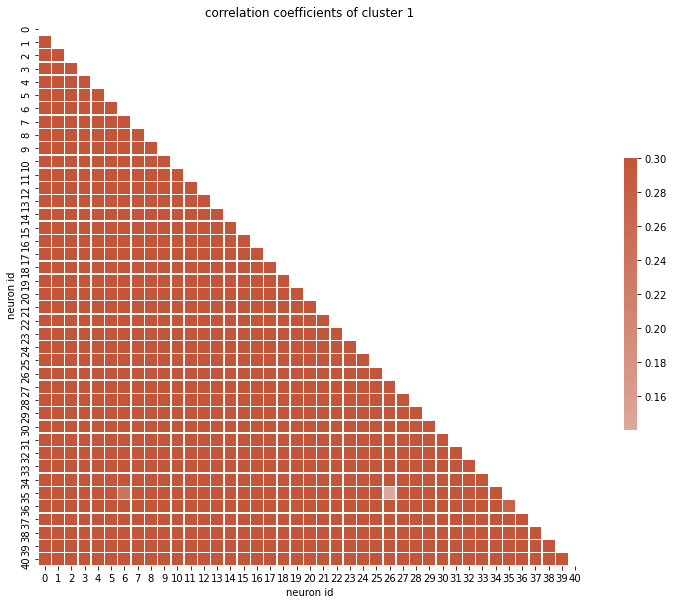

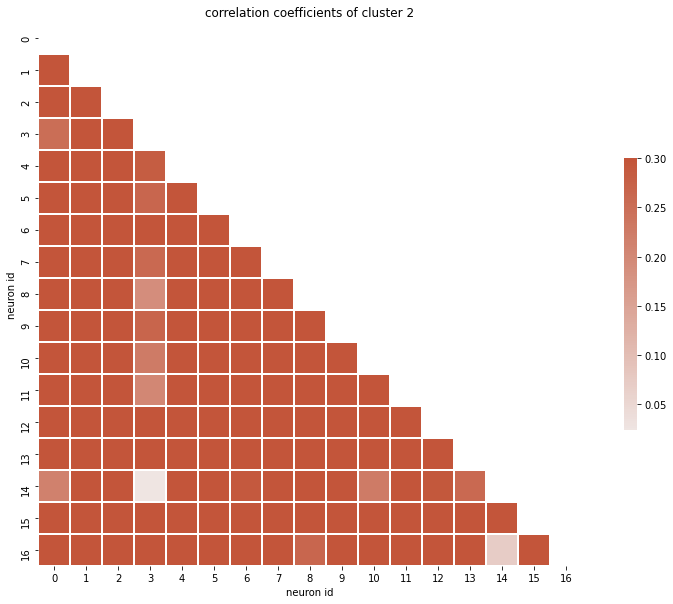

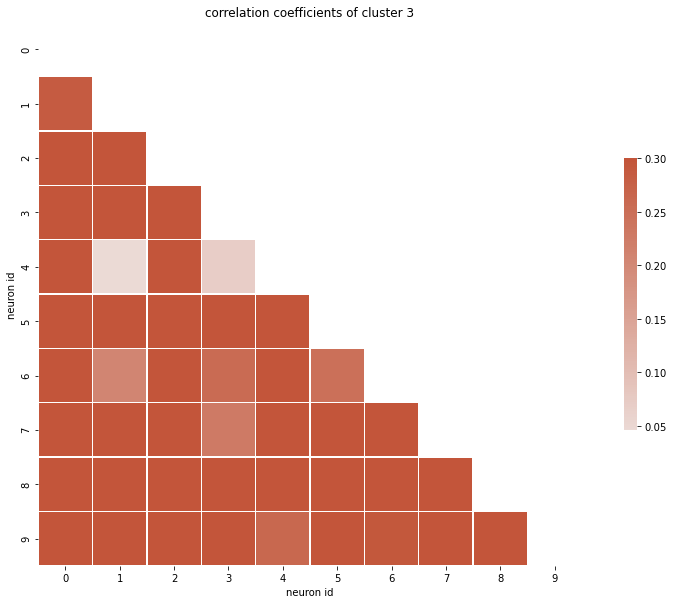

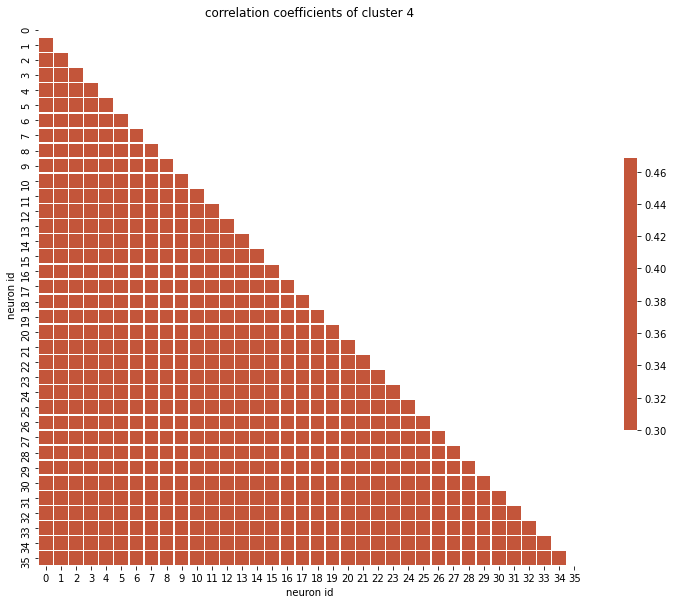

In [53]:
for i in range(len(GMM_names1)):  
    neurons_cluster = np.where(GMM_labels1 == GMM_names1[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X1_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i))

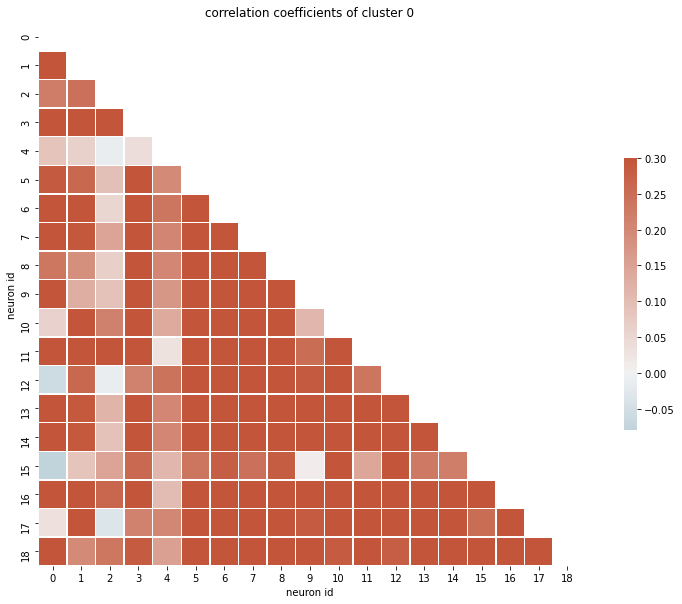

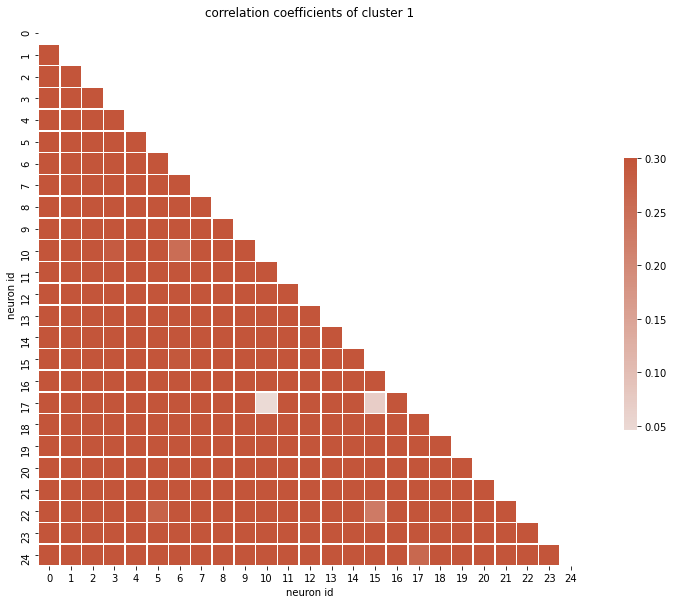

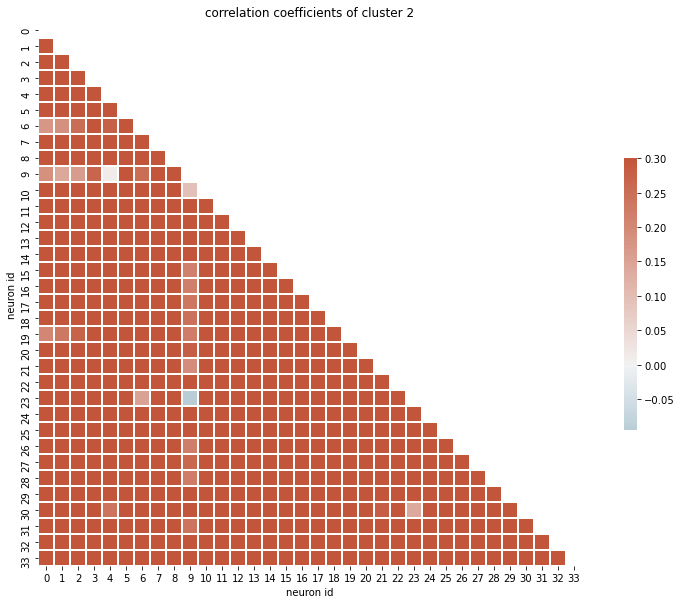

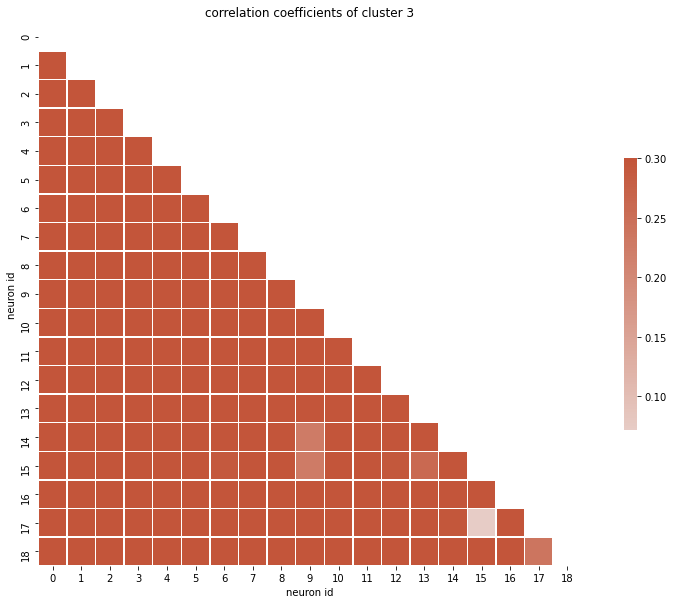

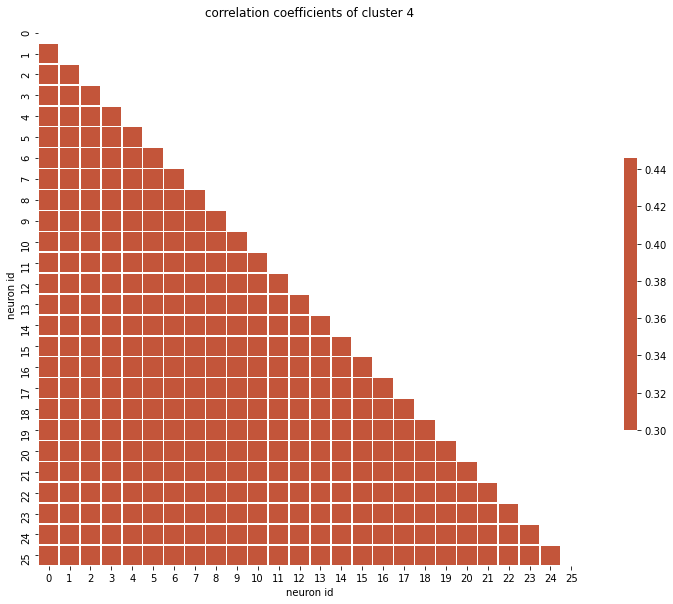

In [54]:

for i in range(len(kmeans_names1)):  
    neurons_cluster = np.where(kmeans_labels1 == kmeans_names1[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X1_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i))